In [13]:
import librosa
import os
import random
import numpy as np
import csv
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from sklearn import metrics
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/My\ Drive/End-to-end_accented2
os.chdir('/content/gdrive/My Drive/End-to-end_accented2')

GRU_ERR.png   GRU_Test_confusion_matrix.png  X_train.npy  Y_train.npy
GRU_LOSS.png  GRU_Val_confusion_matrix.png   X_val.npy	  Y_val.npy
GRU_model2    X_test.npy		     Y_test.npy


In [4]:
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
X_test = np.load("X_test.npy")

Y_train = np.load("Y_train.npy")
Y_val = np.load("Y_val.npy")
Y_test = np.load("Y_test.npy")

In [5]:
class Accent_dataset(Dataset): 
  def __init__(self,x_data,y_data):
    
    self.x_data=x_data[:,:]
    self.y_data=y_data[:]

    self.x_data = self.x_data.reshape(-1,224, 13)
    self.y_data = self.y_data.reshape(-1)

    self.x_data = torch.cuda.FloatTensor(self.x_data)
    self.y_data = torch.cuda.LongTensor(self.y_data)

    print("=== Dataset Download Complete !!")
    print("X shape:",self.x_data.shape)
    print("Y shape:",self.y_data.shape)

    self.len = len(self.x_data)

  def __getitem__(self, index): 
    return self.x_data[index], self.y_data[index] 

  def __len__(self): 
    return self.len

In [6]:
#parameters

num_epochs=300
learning_rate=0.0001
batch_size=512

In [7]:
train_dataset = Accent_dataset(X_train,Y_train)
val_dataset = Accent_dataset(X_val,Y_val)  
test_dataset = Accent_dataset(X_test,Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

=== Dataset Download Complete !!
X shape: torch.Size([9000, 224, 13])
Y shape: torch.Size([9000])
=== Dataset Download Complete !!
X shape: torch.Size([3000, 224, 13])
Y shape: torch.Size([3000])
=== Dataset Download Complete !!
X shape: torch.Size([3000, 224, 13])
Y shape: torch.Size([3000])


In [8]:
#device setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [9]:
#gru model

class GRU_model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,batch_first=True):
        super(GRU_model,self).__init__()

        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers

        self.gru=nn.GRU(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True) #batch, seq_len, feature

        # Readout layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self,x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out,hn = self.gru(x, h0.detach())

        # Decode the hidden state of the last time step
        out = self.fc(out[:,-1])

        return out

gru_model=GRU_model(13,100,3,1).to(device)
print(gru_model)

GRU_model(
  (gru): GRU(13, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)
#, weight_decay=0.001
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

Training start
Epoch:    0/300 | Train loss: 0.010698
Epoch:    0/300 | Validation loss: 1.074118
[Validation set] ERR: 0.641333 | ACC: 0.358667 (1076 / 3000)

Epoch:   10/300 | Train loss: 0.008925
Epoch:   10/300 | Validation loss: 0.863701
[Validation set] ERR: 0.432333 | ACC: 0.567667 (1703 / 3000)

Epoch:   20/300 | Train loss: 0.007213
Epoch:   20/300 | Validation loss: 0.799224
[Validation set] ERR: 0.398333 | ACC: 0.601667 (1805 / 3000)

Epoch:   30/300 | Train loss: 0.007065
Epoch:   30/300 | Validation loss: 0.728514
[Validation set] ERR: 0.360000 | ACC: 0.640000 (1920 / 3000)

Epoch:   40/300 | Train loss: 0.005883
Epoch:   40/300 | Validation loss: 0.688033
[Validation set] ERR: 0.340000 | ACC: 0.660000 (1980 / 3000)

Epoch:   50/300 | Train loss: 0.005993
Epoch:   50/300 | Validation loss: 0.667316
[Validation set] ERR: 0.317667 | ACC: 0.682333 (2047 / 3000)

Epoch:   60/300 | Train loss: 0.005149
Epoch:   60/300 | Validation loss: 0.655429
[Validation set] ERR: 0.306000 |

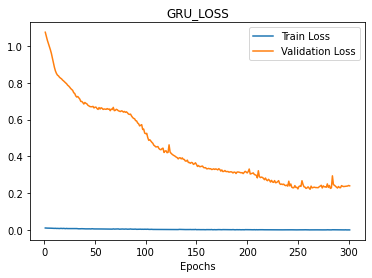

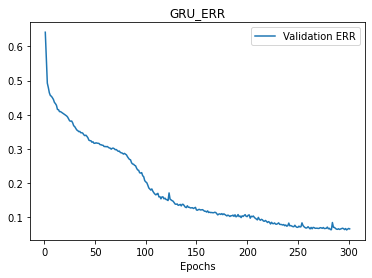

<Figure size 432x288 with 0 Axes>

In [11]:
print("Training start")

train_loss_list=[]
val_loss_list=[]

x_step=[]
y_err=[]

val_predicted_class = []
val_actual_class = []

for epoch in range(num_epochs+1):
  for i, train_data in enumerate(train_loader):
    
    tain_loss = 0.0

    train_accent, train_label = train_data
  
    train_accent=train_accent.to(device)
    train_label=train_label.to(device)
    
    optimizer.zero_grad()

    hypothesis = gru_model(train_accent).to(device)
    trn_loss = criterion(hypothesis, train_label)

    trn_loss.backward()
    optimizer.step()

    tain_loss+=trn_loss

    with torch.no_grad():

      val_loss=0.0
      correct = 0
      total = 0

      for j,val_data in enumerate(val_loader):
        val_accent, val_label = val_data
      
        val_accent=val_accent.to(device)
        val_label=val_label.to(device)

        prediction = gru_model(val_accent)
        vl_loss = criterion(prediction, val_label)
  
        _, predicted = torch.max(prediction.data, 1)

        val_loss+=vl_loss*len(val_label)
        total += val_label.size(0)
        correct += (predicted == val_label).sum()

        val_predicted_class.extend(predicted.tolist())
        val_actual_class.extend(val_label.tolist())
    
    correct = int(correct)
    total = int(total)

  if epoch % 10==0:
    print('Epoch: {:4d}/{} | Train loss: {:.6f}'.format(epoch, num_epochs, tain_loss / 100))
    print("Epoch: {:4d}/{} | Validation loss: {:.6f}".format(epoch, num_epochs, val_loss / total))
    print('[Validation set] ERR: %f | ACC: %f (%d / %d)' % (1 - (correct / total), correct / total, correct, total))
    print()

  #scheduler.step(val_loss)
        
  train_loss_list.append(tain_loss/100)
  val_loss_list.append(val_loss/total)
  train_loss = 0.0

  x_step.append(epoch+1)
  y_err.append(1 - (correct / total))

plt.plot(x_step, train_loss_list, label = "Train Loss")
plt.plot(x_step, val_loss_list, label = "Validation Loss")
plt.xlabel('Epochs')
plt.title('GRU_LOSS')
plt.legend()
plt.savefig('GRU_LOSS.png')
plt.show()
plt.clf()

plt.plot(x_step, y_err, label = "Validation ERR")
plt.xlabel('Epochs')
plt.title('GRU_ERR')
plt.legend()
plt.savefig('GRU_ERR.png')
plt.show()
plt.clf()

[[5067273   96312  254415]
 [ 260859 4436085  721056]
 [ 701609  912633 3803758]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89   5418000
           1       0.81      0.82      0.82   5418000
           2       0.80      0.70      0.75   5418000

    accuracy                           0.82  16254000
   macro avg       0.82      0.82      0.82  16254000
weighted avg       0.82      0.82      0.82  16254000



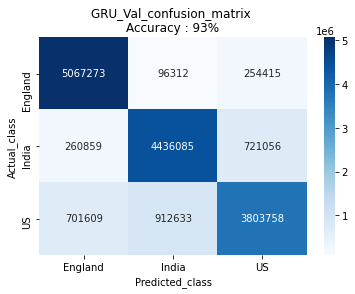

<Figure size 432x288 with 0 Axes>

In [33]:
#Precision (정밀도) : 모델이 Positive라 분류한 것 중 실제값이 Positive인 비율
#Recall (재현도) : 실제값이 Positive인 것 중 모델이 Positive라 분류한 비율
#F1 Score : Precision과 Recall의 조화평균

#0,1,2=England, India, US

print(metrics.confusion_matrix(y_true=val_actual_class, y_pred=val_predicted_class, labels=[0,1,2]))
print(metrics.classification_report(y_true=val_actual_class, y_pred=val_predicted_class, labels=[0,1,2]))

val_confusion = metrics.confusion_matrix(val_actual_class,val_predicted_class)
val_confusion_df=pd.DataFrame(val_confusion,index=['England','India','US'],columns=['England','India','US'])

sns.heatmap(val_confusion_df, annot=True,fmt='d',cmap="Blues")
plt.title('GRU_Val_confusion_matrix \nAccuracy : %d%%' % (100 * correct / total))
plt.xlabel('Predicted_class')
plt.ylabel('Actual_class')
plt.savefig('GRU_Val_confusion_matrix.png')
plt.show()
plt.clf()

In [14]:
print("Test start")

test_correct = 0
test_total = 0

test_actual_class=[]
test_predicted_class=[]

with torch.no_grad():
    for k,test_data in enumerate(test_loader):
        test_accent, test_label = test_data

        test_accent=test_accent.to(device)
        test_label=test_label.to(device)

        test_prediction = gru_model(test_accent)

        _, test_predicted = torch.max(test_prediction.data, 1)

        test_predicted_class.extend(test_predicted.tolist())
        test_actual_class.extend(test_label.tolist())

        test_total += test_label.size(0)
        test_correct += (test_predicted == test_label).sum()

        test_correct = int(test_correct)
        test_total = int(test_total)

print('Accuracy of the model on the testset: %d %%' % (100 * test_correct / test_total))

Test start
Accuracy of the model on the testset: 86 %


[[842  70  88]
 [ 50 859  91]
 [ 46  52 902]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1000
           1       0.88      0.86      0.87      1000
           2       0.83      0.90      0.87      1000

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



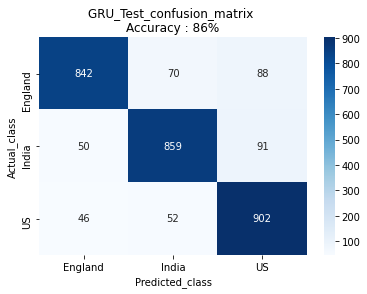

<Figure size 432x288 with 0 Axes>

In [32]:
#Precision (정밀도) : 모델이 Positive라 분류한 것 중 실제값이 Positive인 비율
#Recall (재현도) : 실제값이 Positive인 것 중 모델이 Positive라 분류한 비율
#F1 Score : Precision과 Recall의 조화평균

#0,1,2=England, India, US

print(metrics.confusion_matrix(y_true=test_actual_class, y_pred=test_predicted_class, labels=[0,1,2]))
print(metrics.classification_report(y_true=test_actual_class, y_pred=test_predicted_class, labels=[0,1,2]))

test_confusion = metrics.confusion_matrix(test_actual_class,test_predicted_class)
test_confusion_df=pd.DataFrame(test_confusion,index=['England','India','US'],columns=['England','India','US'])

sns.heatmap(test_confusion_df, annot=True,fmt='d',cmap="Blues")
plt.title('GRU_Test_confusion_matrix \nAccuracy : %d%%' % (100 * test_correct / test_total))
plt.xlabel('Predicted_class')
plt.ylabel('Actual_class')
plt.savefig('GRU_Test_confusion_matrix.png')
plt.show()
plt.clf()